In [2]:
import os
import glob
import cv2
import csv
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import colors
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import BSpline, make_interp_spline
from scipy.ndimage import zoom


#LATEX CONFIG 
import matplotlib as mpl
from matplotlib import rc
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['mathtext.default']='regular'
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amssymb}')
fontProperties = {'family':'sans-serif','sans-serif':['Helvetica'], 'weight' : 'normal', 'size' : 20}
rc('font',**fontProperties)

In [ ]:
# To obtain dentition distances we use SSM developed by "Developing a three-dimensional statistical shape model of normal dentition using an automated algorithm and normal samples" - Kim et al.
# https://link.springer.com/article/10.1007/s00784-022-04824-z

In [ ]:
if os.getcwd().split('/')[-1] != 'CBCT_SEG_E2E':
    os.chdir('../')
os.getcwd()

In [5]:
images = sorted(glob.glob('data/SSM/*.png'))

In [6]:
images

['data/SSM/female_mandible.png',
 'data/SSM/female_maxilla.png',
 'data/SSM/male_mandible.png',
 'data/SSM/male_maxilla.png']

In [7]:
images_arrays = [cv2.imread(img_path) for img_path in images]
[img.shape for img in images_arrays]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


[(407, 572, 3), (429, 572, 3), (407, 572, 3), (429, 572, 3)]

Add border to the image

In [8]:
bordersize=5
images_arrays_border = [
cv2.copyMakeBorder(
    img,
    top=bordersize,
    bottom=bordersize,
    left=bordersize,
    right=bordersize,
    borderType=cv2.BORDER_CONSTANT,
    value=[255, 255, 255]
) for img in images_arrays
]

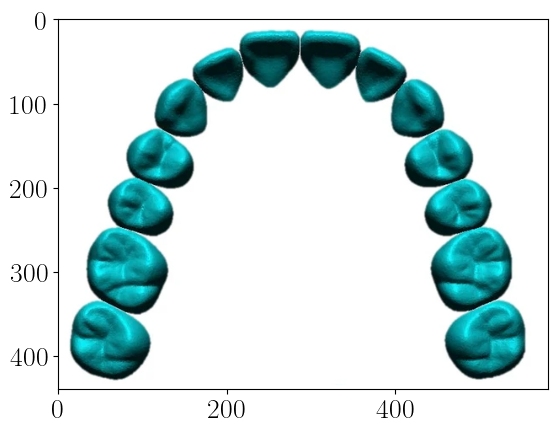

In [9]:
plt.imshow(images_arrays_border[1], cmap='gray')

In [10]:
gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images_arrays_border]

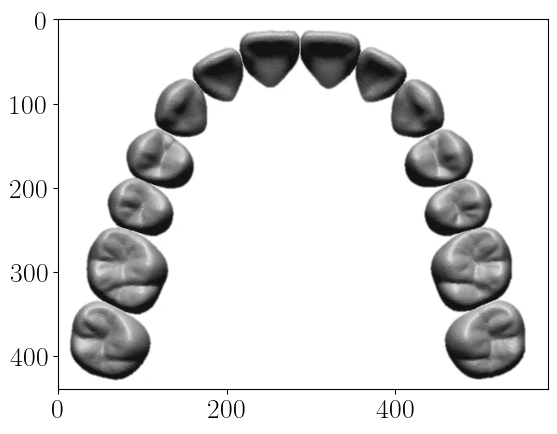

In [11]:
plt.imshow(gray_images[1], cmap='gray')

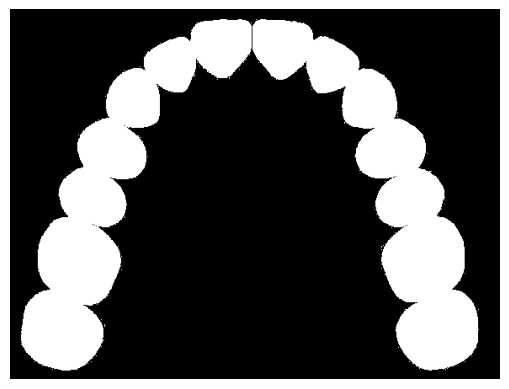

In [12]:
thresh_images = [cv2.threshold(gray_img, 250, 255, cv2.THRESH_BINARY_INV)[1] for gray_img in gray_images]
plt.imshow(thresh_images[1], cmap='gray')
plt.axis('off')
plt.savefig('figures/SSM/ssm_mask.png', dpi=300, bbox_inches='tight')

In [13]:
id = 1
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh_images[id],cv2.MORPH_OPEN, kernel, iterations = 1)
# sure_bg = cv2.dilate(opening,kernel,iterations=3)
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.55*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)
sure_fg = cv2.dilate(sure_fg,kernel,iterations=1)
unknown = cv2.subtract(opening,sure_fg)

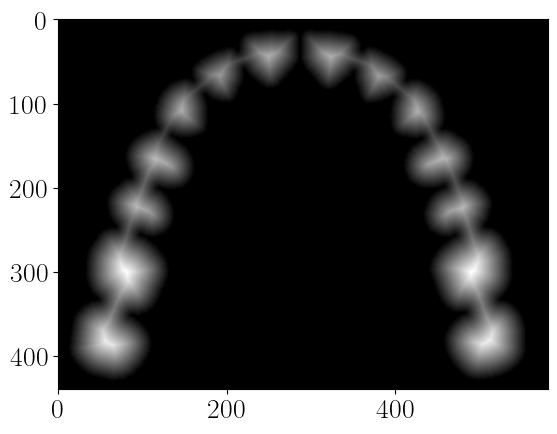

In [14]:
plt.imshow(dist_transform, cmap='gray')

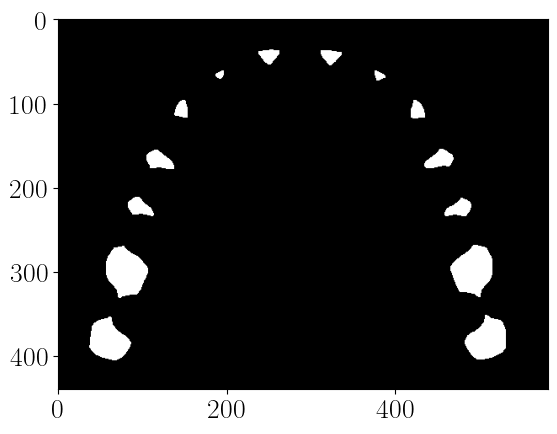

In [15]:
plt.imshow(sure_fg, cmap='gray')

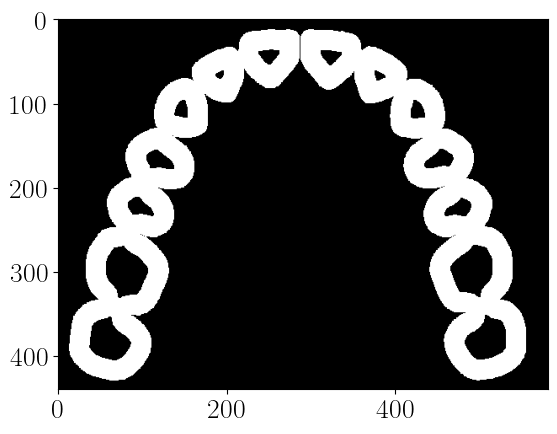

In [16]:
plt.imshow(unknown, cmap='gray')

In [17]:
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==255] = 0

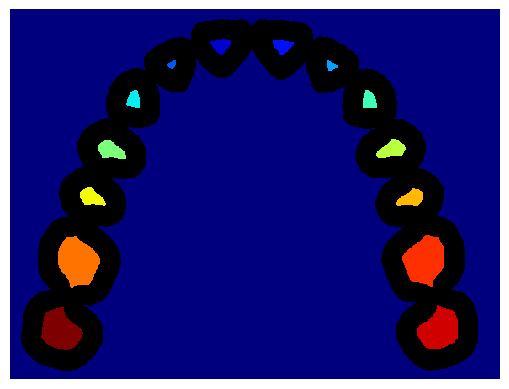

In [18]:
from matplotlib import colormaps as cm
from matplotlib import pyplot as plt
plt.figure()
colormap = cm.get_cmap('jet')
colormap.set_bad(color='black')
colormap.set_under(color='black')
instance_markers = markers.copy()
# instance_markers[instance_markers==-1]=0
plt.axis('off')
plt.imshow(instance_markers-1, cmap=colormap, interpolation='none', vmin=0)
plt.savefig('figures/SSM/ssm_instance_markers.png', dpi=300, bbox_inches='tight')

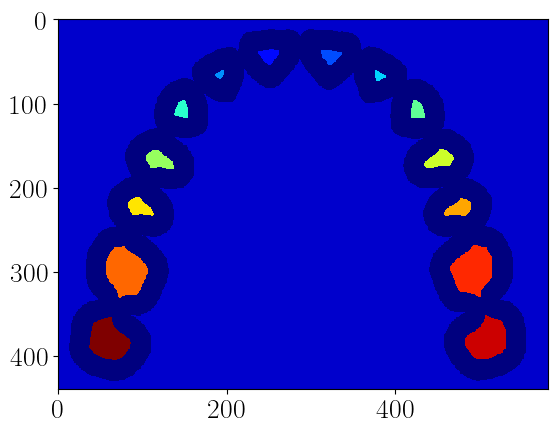

In [19]:
plt.imshow(markers, cmap='jet', interpolation='none')

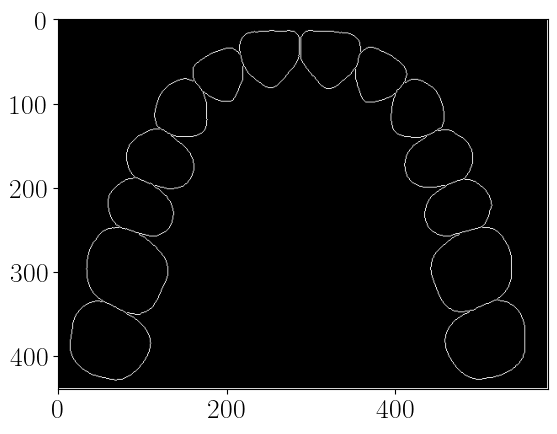

In [20]:
watershed_out = cv2.watershed(images_arrays_border[id], markers)
mask = np.zeros(gray_images[id].shape, gray_images[id].dtype)
mask[watershed_out == -1] = 255
plt.imshow(mask, cmap='gray')

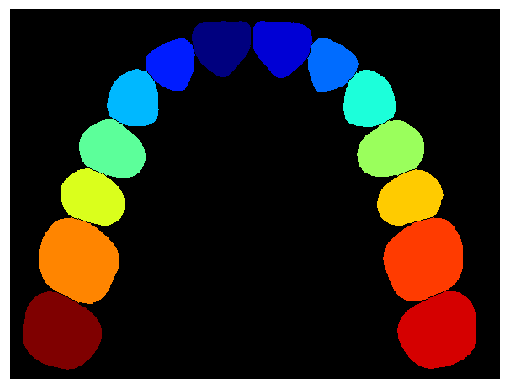

In [21]:
from matplotlib import colormaps as cm
colormap = cm.get_cmap('jet')
colormap.set_bad(color='black')
colormap.set_under(color='black')
instances = watershed_out.copy()
instances[instances==-1]=0
plt.axis('off')
plt.imshow(instances-2, cmap=colormap, interpolation='none', vmin=0)
plt.savefig('figures/SSM/ssm_instance.png', dpi=300, bbox_inches='tight')

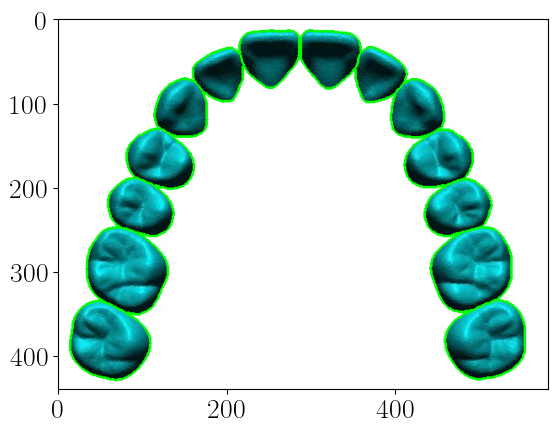

In [22]:
img2 = images_arrays_border[id].copy()

contours, hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)    
for idx, c in enumerate(contours[:-2]):
    cv2.drawContours(img2, c, -1, (0, 255, 0), 2)
plt.imshow(img2)

In [23]:
contours_filtered = []
for idx, c in enumerate(contours):
    area = cv2.contourArea(c)
    if area > 2500 and area < 9000:
        contours_filtered.append(c)
len(contours_filtered)

14

In [24]:
def get_colormap(file_path : str ='csv_files/colormap_slicer.csv', num_classes=32) -> colors.ListedColormap:
    tooth_colors = pd.read_csv(file_path, delimiter=";", header=None)
    tooth_colors_df = tooth_colors.iloc[:,2:5]
    tooth_colors_df.columns = ['r','g','b']
    slicer_colorspace = tooth_colors_df.to_numpy()/255
    slicer_map = colors.ListedColormap(slicer_colorspace[:num_classes+1], 'slicer_colors')
    return slicer_map

slicer_cmap = get_colormap()
slicer_cmap_rgb = slicer_cmap.colors*255
slicer_cmap_rgb=slicer_cmap_rgb.astype(np.uint8)

In [25]:
x_centers = []
for idx, c in enumerate(contours_filtered):
    x_centers.append(c[:,0][:,0].mean())

In [26]:
contours = [x for _, x in sorted(zip(x_centers, contours_filtered))]

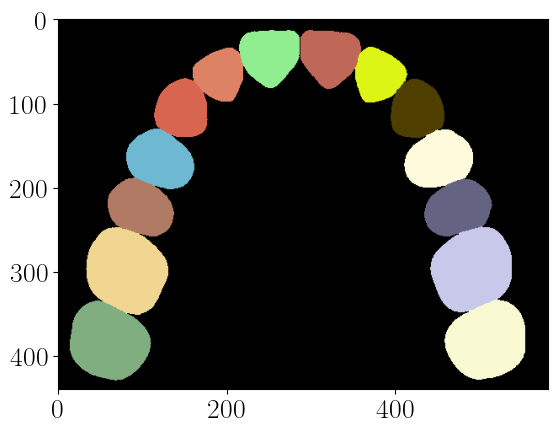

In [27]:
img_tooth = np.zeros(img2.shape, img2.dtype)
for idx, c in enumerate(contours):
    cv2.fillPoly(img_tooth, [c], slicer_cmap_rgb[idx+1].tolist())
plt.imshow(img_tooth)

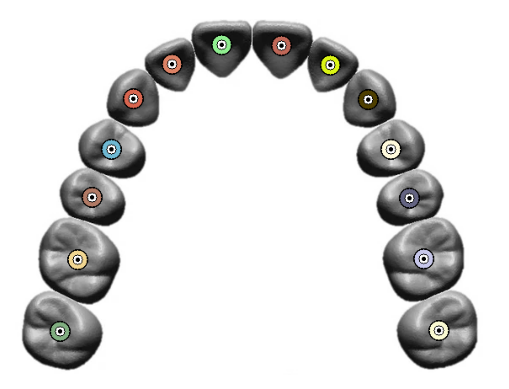

In [28]:
img_centers = cv2.cvtColor(gray_images[1], cv2.COLOR_GRAY2BGR)
tooth_positions = []
tooth_positions.append({0:img2.shape[:2]})
for idx, c in enumerate(contours):
    M = cv2.moments(c)
    cX = (M["m10"] / M["m00"])
    cY = (M["m01"] / M["m00"])
    tooth_positions.append({idx+1:[cX,cY]})
    cX=int(cX)
    cY=int(cY)
    cv2.circle(img_centers, (cX, cY), 11, (0,0,0), 2)
    cv2.circle(img_centers, (cX, cY), 11, slicer_cmap_rgb[idx+1].tolist(), -1)
    cv2.circle(img_centers, (cX, cY), 3, (0,0,0), -1)
    cv2.circle(img_centers, (cX, cY), 4, (255,255,255), 2)
    cv2.circle(img_centers, (cX, cY), 6, (0,0,0), 1)
    #positions (x,y)
    # img_centers[cY+5:cY+35,cX+25:cX+95,:]=(255,255,255)
    # cv2.rectangle(img_centers, (cX+25, cY+5), (cX+95, cY+35), (0,0,0), 1)
    # cv2.putText(img_centers, f"{cX},{cY}", (cX + 30, cY + 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2, lineType=cv2.LINE_8)
plt.axis('off')
plt.imshow(img_centers)
plt.savefig('figures/SSM/centroids.png', bbox_inches='tight', dpi=600)
 

Extraction SSM tooth positions based on: "Developing a three-dimensional statistical shape model of normal dentition using an automated algorithm and normal samples" - Kim et al.

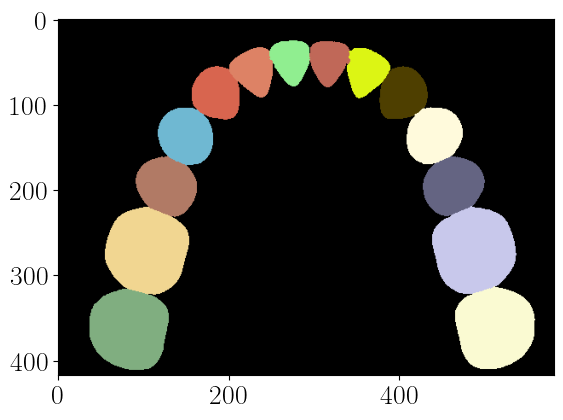

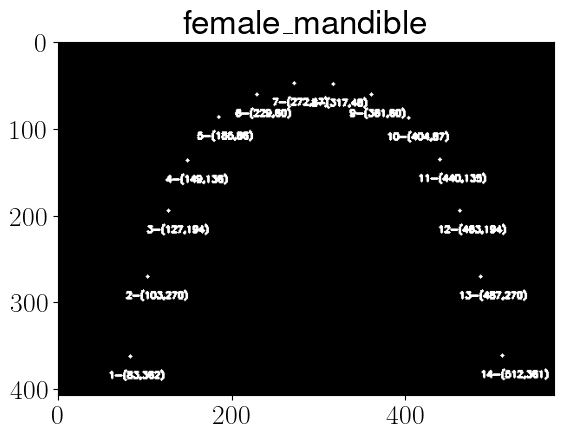

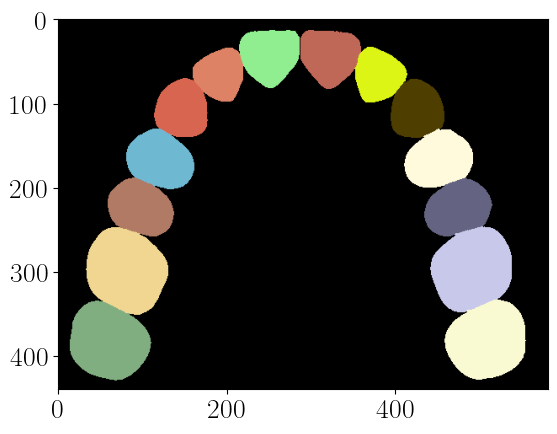

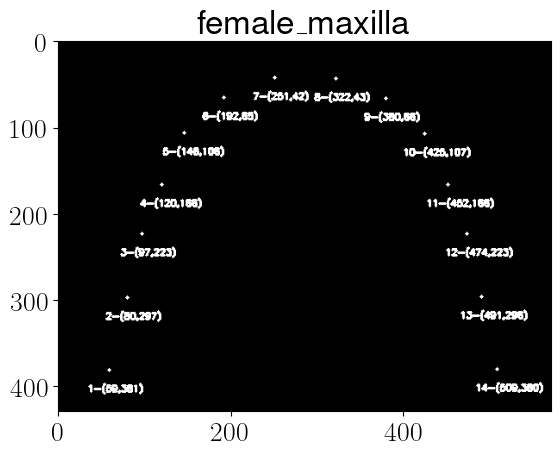

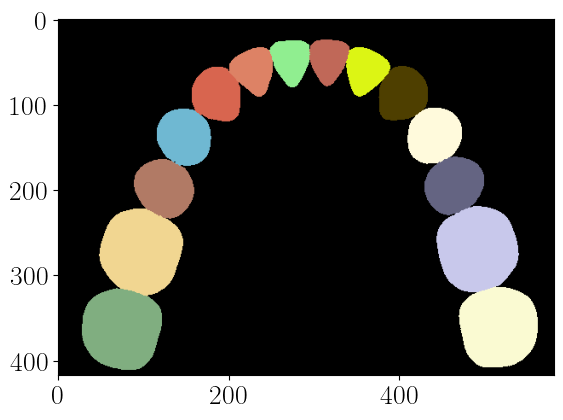

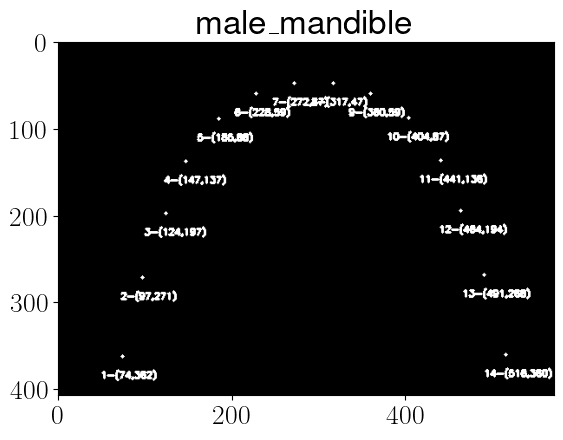

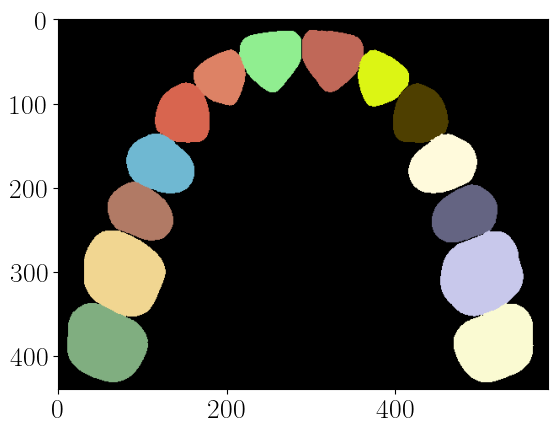

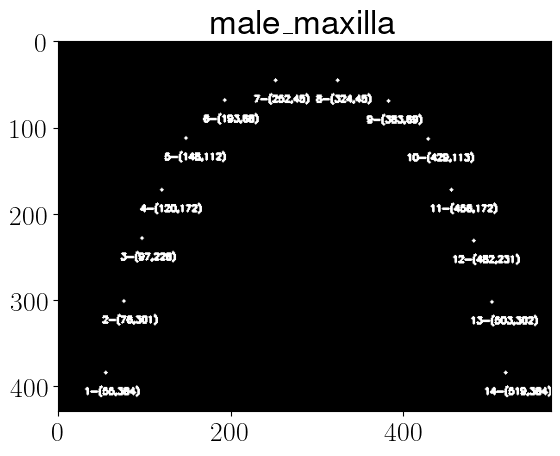

In [29]:
distances = [0.45, 0.55, 0.45, 0.55]
bordersize=5
tooth_positions_all = []
titles = ['male']
only_positions = []
mandible_image_shape = images_arrays[0].shape
maxilla_image_shape = images_arrays[1].shape
for id, img in enumerate(images_arrays):
    img_border=cv2.copyMakeBorder(img, top=bordersize, bottom=bordersize, left=bordersize, right=bordersize,
                                  borderType=cv2.BORDER_CONSTANT, value=[255, 255, 255])
    gray_img = cv2.cvtColor(img_border, cv2.COLOR_BGR2GRAY)
    tresh_img = cv2.threshold(gray_img, 250, 255, cv2.THRESH_BINARY_INV)[1]
    #prepare contour for watershed - to obtain seeds
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(tresh_img, cv2.MORPH_OPEN, kernel, iterations = 3)
    # sure_bg = cv2.dilate(opening,kernel,iterations=3)
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,distances[id]*dist_transform.max(),255,0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(opening,sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers+1
    markers[unknown==255] = 0
    # apply watershed on RGB image based on found markers
    markers = cv2.watershed(cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR), markers)
    #extract contours based on watershed from 
    markers1 = markers.astype(np.uint8)
    ret, m2 = cv2.threshold(markers1, 1, 15, cv2.THRESH_BINARY)
    ret, m3 = cv2.threshold(markers1, 15, 255, cv2.THRESH_BINARY)
    img_normalized = cv2.normalize(m3, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_8UC1) * 255
    out = cv2.subtract(img_normalized, m2)
    # find contours
    contours, hierarchy = cv2.findContours(out, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)    
    contours_filtered = []
    for idx, c in enumerate(contours):
        area = cv2.contourArea(c)
        if area > 1500 and area < 9000:
            contours_filtered.append(c)
    # sort contours based on x axis
    x_centers = []
    for c in contours_filtered:
        x_centers.append(c[:,0][:,0].mean())
    contours = [x for _, x in sorted(zip(x_centers, contours_filtered))]
    # draw contours
    img_tooth = np.zeros(img_border.shape, np.uint8)
    for idx, c in enumerate(contours):
        cv2.fillPoly(img_tooth, [c], slicer_cmap_rgb[idx+1].tolist())
    plt.figure()
    plt.imshow(img_tooth)
    # get segments centers
    img_centers = np.zeros(img.shape, np.uint8)
    tooth_positions = []
    tooth_positions.append({0:img.shape[:2]})
    only_positions.append([img.shape[1], img.shape[0]])
    for idx, c in enumerate(contours):
        M = cv2.moments(c)
        cX = (M["m10"] / M["m00"])
        cY = (M["m01"] / M["m00"])
        tooth_positions.append({idx+1:[cX,cY]})
        only_positions.append([cX,cY])
        cX=int(cX)
        cY=int(cY)
        cv2.circle(img_centers, (cX, cY), 2, (255, 255, 255), -1)
        cv2.putText(img_centers, f"{idx+1}-({cX},{cY})", (cX - 25, cY + 25),cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255, 255, 255), 2)
    tooth_positions_all.append(tooth_positions)
    plt.figure()
    plt.title(images[id].split('/')[-1].split('.')[0])
    plt.imshow(img_centers)

In [30]:
with open("csv_files/tooth_positions.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(only_positions)

In [31]:
female_mandible = np.array(only_positions[1:15])
female_maxilla = np.array(only_positions[16:30])
male_mandible = np.array(only_positions[31:45])
male_maxilla = np.array(only_positions[46:60])


In [32]:
average_mandible = (female_mandible + male_mandible)/2
average_maxilla = (female_maxilla + male_maxilla)/2
average_mandible[:,0] = average_mandible[:,0]/mandible_image_shape[1]
average_mandible[:,1] = average_mandible[:,1]/mandible_image_shape[0]
average_maxilla[:,0] = average_maxilla[:,0]/maxilla_image_shape[1]
average_maxilla[:,1] = average_maxilla[:,1]/maxilla_image_shape[0]

In [33]:
np.set_printoptions(suppress=True, precision=4)

In [34]:
mandible_origin = [average_mandible[6,0]+(average_mandible[7,0] - average_mandible[6,0])/2, average_mandible[:,1].min()]
maxilla_origin = [average_maxilla[6,0]+(average_maxilla[7,0] - average_maxilla[6,0])/2, average_maxilla[:,1].min()]

In [35]:
norm_average_mandible = np.subtract(average_mandible, mandible_origin)
norm_average_maxilla = np.subtract(average_maxilla, maxilla_origin)

In [36]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = False

Text(0.35, 0.4, 'L(Q2)')

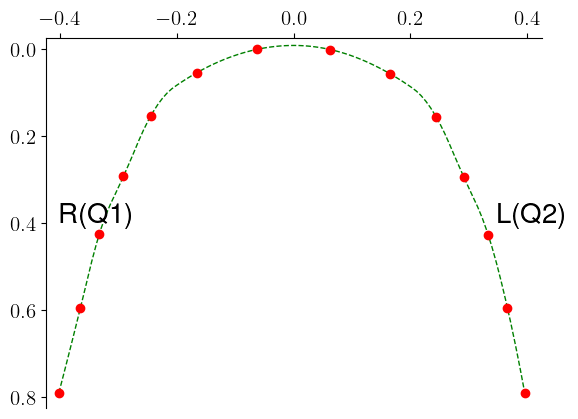

In [37]:
#MAXILLARY: Q1,Q2
x=norm_average_maxilla[:,0]
y=norm_average_maxilla[:,1]
xx = np.linspace(x.min(), x.max(), num=100)
spl = make_interp_spline(x, y, k=2) 
smooth_y = spl(xx)
plt.plot(xx, smooth_y, 'green',  linestyle='--', linewidth=1)
plt.plot(x, y, 'ro')
plt.xlim([-0.425, 0.425])
plt.ylim([-0.025, 0.825])
plt.gca().invert_yaxis()
plt.tick_params(axis='both', which='major', labelsize=15)
plt.text(-0.4,0.4,'R(Q1)')
plt.text(0.35,0.4,'L(Q2)')
# plt.xlabel('x', fontsize=12)
# plt.ylabel('y', fontsize=12, rotation=0, labelpad=15)
# plt.grid(visible=True, which='both', color='0.65', linestyle='-')

Text(0.4, 0.4, 'R(Q4)')

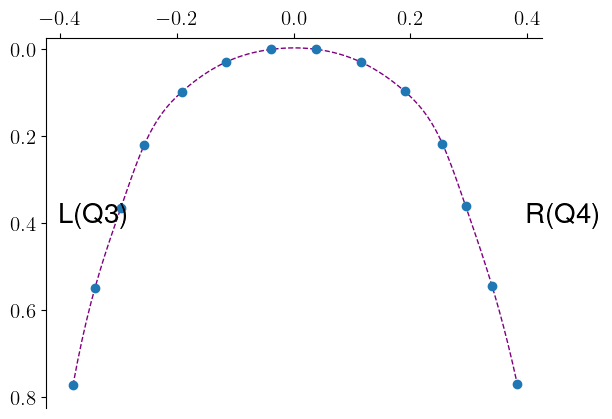

In [38]:
#MANDIBULAR: Q3,Q4
x=norm_average_mandible[:,0]
y=norm_average_mandible[:,1]
xx = np.linspace(x.min(), x.max(), num=100)
spl = make_interp_spline(x, y, k=3) 
smooth_y = spl(xx)
plt.plot(xx, smooth_y, 'purple',  linestyle='--', linewidth=1)
plt.plot(x, y, 'o')
plt.xlim([-0.425, 0.425])
plt.ylim([-0.025, 0.825])
plt.gca().invert_yaxis()
plt.tick_params(axis='both', which='major', labelsize=15)
plt.text(-0.4, 0.4,'L(Q3)')
plt.text(0.4, 0.4,'R(Q4)')
# plt.xlabel('x', fontsize=12)
# plt.ylabel('y', fontsize=12, rotation=0, labelpad=15)
# plt.grid(visible=True, which='both', color='0.65', linestyle='-')


Individual quadrant distances

In [39]:
norm_average_maxilla, norm_average_mandible

(array([[-0.4025,  0.7902],
        [-0.3657,  0.5956],
        [-0.3329,  0.4242],
        [-0.2918,  0.2922],
        [-0.2449,  0.153 ],
        [-0.1658,  0.0536],
        [-0.0626,  0.    ],
        [ 0.0626,  0.0005],
        [ 0.1646,  0.0558],
        [ 0.244 ,  0.1549],
        [ 0.2912,  0.2926],
        [ 0.3337,  0.4281],
        [ 0.3664,  0.5949],
        [ 0.3959,  0.7897]]),
 array([[-0.3782,  0.7726],
        [-0.3404,  0.5482],
        [-0.2961,  0.3645],
        [-0.2559,  0.219 ],
        [-0.1913,  0.0973],
        [-0.1155,  0.029 ],
        [-0.039 ,  0.0002],
        [ 0.039 ,  0.    ],
        [ 0.1154,  0.0295],
        [ 0.1905,  0.0969],
        [ 0.2548,  0.2166],
        [ 0.2946,  0.3604],
        [ 0.34  ,  0.5448],
        [ 0.3829,  0.7685]]))

In [40]:
q1 = np.sort(norm_average_maxilla[0:7], axis=1)[::-1]
q2 = np.sort(norm_average_maxilla[7:15], axis=0)
#horizontal flip (mandbile was upside-down)
q3 = np.sort(norm_average_mandible[0:7], axis=1)[::-1] * (-1,1)
q4 = np.sort(norm_average_mandible[7:15], axis=0) * (-1,1)
#q3 and q2 (also q1 and a4) are on the same side, so X coordiante has to have the same sign

In [41]:
third_molars = []
for q in [q1,q2, q3, q4]:
    vec_56= q[-2] - q[-3]
    vec_67= q[-1] - q[-2]
    vec_78 = vec_67/vec_56 * vec_67
    t8 = np.round(q[-1] + vec_78, 2)
    third_molars.append(t8)
third_molars

[array([-0.44,  1.01]),
 array([0.42, 1.02]),
 array([0.41, 1.05]),
 array([-0.42,  1.04])]

In [42]:
#add wisdom tooth
q1 = np.append(q1,[third_molars[0]], axis=0)
q2 = np.append(q2,[third_molars[1]], axis=0)
q3 = np.append(q3,[third_molars[2]], axis=0)
q4 = np.append(q4,[third_molars[3]], axis=0)

In [43]:
#FDI quadrant tooth ids
# Q1|Q2 -> ... 12, 11 | 21, 22 ...
# Q3|Q4 -> ... 32, 31 | 41, 42 ...
# Q1: 11, 12, 13, 14, 15, 16, 17, 18
# Q2: 21, 22, 23, 24, 25, 26, 27, 28
# Q3: 31, 32, 33, 34, 35, 36, 37, 38
# Q4: 41, 42, 43, 44, 45, 46, 47, 48

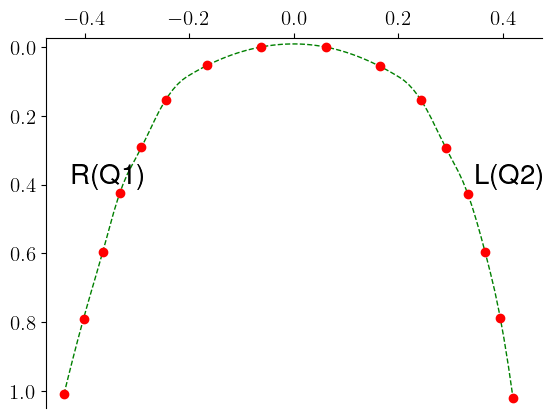

In [44]:
x=np.concatenate((q1[::-1],q2))[:,0]
y=np.concatenate((q1[::-1],q2))[:,1]
xx = np.linspace(x.min(), x.max(), num=100)
spl = make_interp_spline(x, y, k=2) 
smooth_y = spl(xx)
plt.plot(xx, smooth_y, 'green',  linestyle='--', linewidth=1)
plt.plot(x, y, 'ro')
plt.xlim([-0.475, 0.475])
plt.ylim([-0.025, 1.05])
plt.gca().invert_yaxis()
plt.text(-0.425,0.4,'R(Q1)')
plt.text(0.35,0.4,'L(Q2)')
plt.tick_params(axis='both', which='major', labelsize=15)
# plt.xlabel('x', fontsize=12)
# plt.ylabel('y', fontsize=12, rotation=0, labelpad=15)
# plt.grid(visible=True, which='both', color='0.65', linestyle='-')

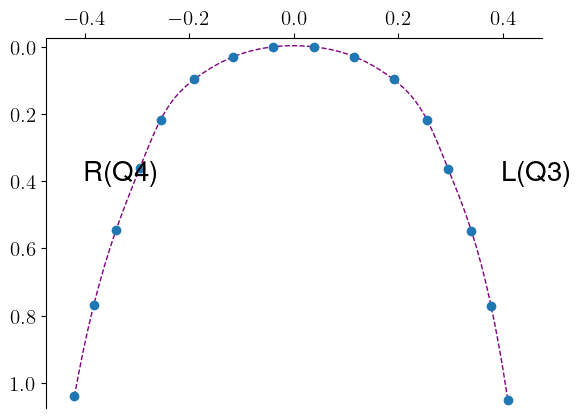

In [45]:
# reorder q4 (from 8 to 1) - spline interpolation requires order from left to right
x=np.concatenate((q4[::-1], q3))[:,0]
y=np.concatenate((q4[::-1], q3))[:,1]
xx = np.linspace(x.min(), x.max(), num=100)
spl = make_interp_spline(x, y, k=3) 
smooth_y = spl(xx)
plt.plot(xx, smooth_y, 'purple',  linestyle='--', linewidth=1)
plt.plot(x, y, 'o')
plt.xlim([-0.475, 0.475])
plt.ylim([-0.025, 1.075])
plt.gca().invert_yaxis()
plt.text(0.4, 0.4,'L(Q3)')
plt.text(-0.4, 0.4,'R(Q4)')
plt.tick_params(axis='both', which='major', labelsize=15)
# plt.xlabel('x', fontsize=12)
# plt.ylabel('y', fontsize=12, rotation=0, labelpad=15)
# plt.grid(visible=True, which='both', color='0.65', linestyle='-')

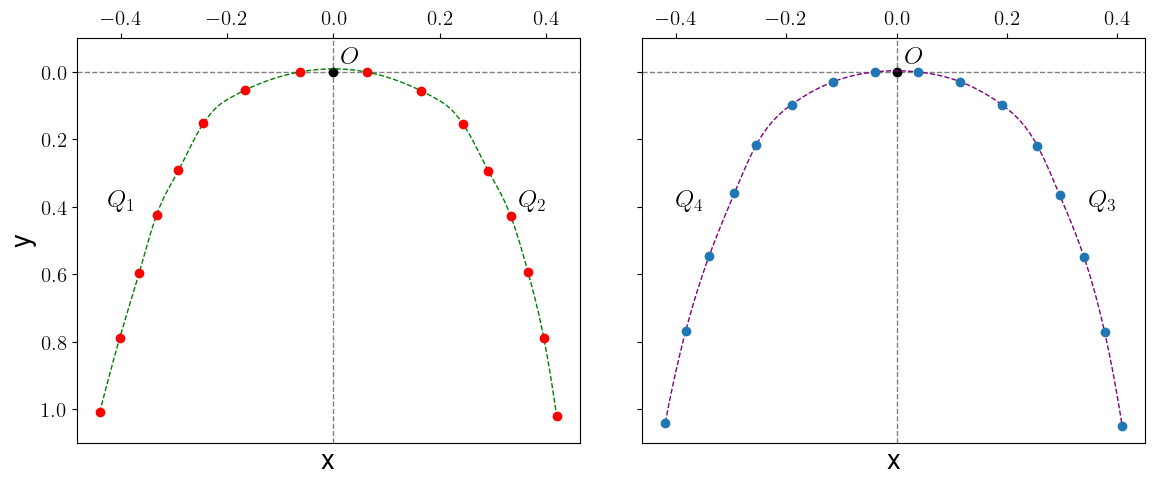

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,5), sharey=True)
ax[0].set_ylim([-0.1, 1.1])
fig.tight_layout()
#MANDIBLE
x=np.concatenate((q1[::-1],q2))[:,0]
y=np.concatenate((q1[::-1],q2))[:,1]
xx = np.linspace(x.min(), x.max(), num=100)
spl = make_interp_spline(x, y, k=2) 
smooth_y = spl(xx)
# lines and subscriptions
ax[0].text(-0.425,0.4,'$Q_1$', fontsize=18)
ax[0].text(0.35,0.4,'$Q_2$', fontsize=18)
ax[0].axvline(x=0, c="gray", linewidth=1, linestyle='--')
ax[0].axhline(y=0, c="gray", linewidth=1, linestyle='--')
ax[0].plot(0, 0, 'o', c='black')
ax[0].text(0.015, -0.025, '$O$', fontsize=18)
ax[0].tick_params(axis='both', which='major', labelsize=15)
#main plot 
ax[0].plot(xx, smooth_y, 'green',  linestyle='--', linewidth=1)
# ax[0].set_aspect('equal')
ax[0].plot(x, y, 'ro')
# ax[0].xlim([-0.475, 0.475])
# ax[0].ylim([-0.025, 1.05])
ax[0].invert_yaxis()
ax[0].set_ylabel('y', fontsize=20)
ax[0].set_xlabel('x', fontsize=20)

ax[0].spines['right'].set_visible(True)
ax[0].spines['bottom'].set_visible(True)
#MAXILLA
x=np.concatenate((q4[::-1], q3))[:,0]
y=np.concatenate((q4[::-1], q3))[:,1]
xx = np.linspace(x.min(), x.max(), num=100)
spl = make_interp_spline(x, y, k=3) 
smooth_y = spl(xx)
# lines and subscriptions
ax[1].text(0.35, 0.4,'$Q_3$', fontsize=18)
ax[1].text(-0.4, 0.4,'$Q_4$', fontsize=18)
ax[1].axvline(x=0, c="gray", linewidth=1, linestyle='--')
ax[1].axhline(y=0, c="gray", linewidth=1, linestyle='--')
ax[1].plot(0, 0, 'o', c='black')
ax[1].text(0.015, -0.025,'$O$', fontsize=18)
ax[1].tick_params(axis='both', which='major', labelsize=15)
#main plot
ax[1].plot(xx, smooth_y, 'purple',  linestyle='--', linewidth=1)
ax[1].plot(x, y, 'o')
# ax[1].xlim([-0.475, 0.475])
# ax[1].ylim([-0.025, 1.075])
# ax[1].invert_yaxis()
ax[1].set_xlabel('x', fontsize=20)
ax[1].spines['right'].set_visible(True)
ax[1].spines['bottom'].set_visible(True)

# plt.show()
plt.savefig('figures/SSM/centroids_xy.png', bbox_inches='tight', dpi=600)

In [47]:
def get_distances_interquartile(q1, q2):
    template = np.zeros((8,8))
    for i in range(0,8):
        q12_dist = []
        for j, (x,y) in enumerate(q1):
            d = np.sqrt((x - q2[i][0])**2 + (y - q2[i][1])**2)
            q12_dist.append(d)
        template[:,i]=np.array(q12_dist)
    #normalise to 0-1
    template /= template.max()
    return template

In [48]:
def get_combinations_test(q = ['q1','q2','q3','q4']):
    all = []
    for i, q_i in enumerate(q):
        col = []
        for j, q_j in enumerate(q):
            col.append(f"{q_i}{q_j}")
        all.append(col)
    return all
get_combinations_test()


[['q1q1', 'q1q2', 'q1q3', 'q1q4'],
 ['q2q1', 'q2q2', 'q2q3', 'q2q4'],
 ['q3q1', 'q3q2', 'q3q3', 'q3q4'],
 ['q4q1', 'q4q2', 'q4q3', 'q4q4']]

In [49]:
def get_combinations(q, penalties_matrix, penalty_mode="multiply"):
    matrix = []
    for i, q_i in enumerate(q):
        row = []
        for j, q_j in enumerate(q):
            if penalty_mode=="multiply":
                row.append(get_distances_interquartile(q_i, q_j) * penalties_matrix[i][j])
            elif  penalty_mode=="add":
                row.append(get_distances_interquartile(q_i, q_j) + penalties_matrix[i][j])
        matrix.append(np.concatenate(row, axis=1))
    return np.concatenate(matrix, axis=0)

In [50]:

def fdi2american(matrix):
    container = np.zeros_like(matrix)
    #i - rows, j - columns
    for i in range(4):
        for j in range(4):
            matrix_subset = matrix[8*i:8*(i+1),8*j:8*(j+1)]
            if i % 2 == 0:
                matrix_subset = np.flipud(matrix_subset)
            if j % 2 == 0:
                matrix_subset = np.fliplr(matrix_subset)
            container[8*i:8*(i+1),8*j:8*(j+1)]=matrix_subset
    return container

___

# WASSERSTEIN MATRICES BASED ON SSM

In [51]:
def create_visualize_wass_matrix(quadrants_distances_ssm, weights=[1, 1, 1, 1], config_name="wasserstein_matrix", mode="add", geometry='arch', is_sqrt=False,
                                 plot_title=None, isShowBackground=True, isAnnotateValues=True, isShowPreview2D=True, isShowPreview3D=True,
                                 isSavePreview2D=True, isSavePreview3D=True, isSaveWeights=True, precomputed_matrix=None,
                                 background_val=1.0, background_FN_val=0.0, background_FP_val=0.0, is_normalize=False, vmax=1.0, above_color='white'):
    #SETUP PENALTIES
    # h-horizontal, v-vertical, d-diagonal
    ii, hp, vp, dp = weights
    penalties_matrix_quadrants = np.array([[ii, hp, dp, vp],
                                           [hp, ii, vp, dp],
                                           [dp, vp, ii, hp],
                                           [vp, dp, hp, ii]])
    print("quadrant weights: \n", penalties_matrix_quadrants)
    
    #SETUP MATRIX
    if geometry == "quadrant":
        #do not extend geometry over arch - narrow it to quadrant
        #flip quadrants within arch over Y axis
        q1, q2, q3, q4 = quadrants_distances_ssm
        quadrants_distances_ssm = np.abs(q1), q2, q3, np.abs(q4)

    penatlies_matrix = get_combinations(quadrants_distances_ssm, penalties_matrix_quadrants, penalty_mode=mode)
        
    penatlies_matrix /= penatlies_matrix.max() #normalize
    if is_sqrt:
        penatlies_matrix = np.sqrt(penatlies_matrix)        
    #change order of columns to adapt for american labels notation used in training
    penatlies_matrix_american = fdi2american(penatlies_matrix)
    
    if precomputed_matrix is not None:
        print("using precomputed matrix")
        penatlies_matrix_american = precomputed_matrix
    
    #VISUALIZE 2D
    if isShowPreview2D:
        dist_matrix = penatlies_matrix_american
        cmap: plt.Colormap = plt.colormaps["Spectral_r"].copy()
        cmap.set_over(above_color)
        if isShowBackground:
            if background_FN_val > 0 and background_FN_val > 0:
                dist_matrix = np.concatenate([np.ones((1,32))*background_FP_val, dist_matrix])
                dist_matrix = np.concatenate([np.ones((33,1))*background_FN_val, dist_matrix], axis=1)
            else:
                dist_matrix = np.concatenate([np.ones((1,32))*background_val, dist_matrix])
                dist_matrix = np.concatenate([np.ones((33,1))*background_val, dist_matrix], axis=1)
            dist_matrix[0][0]=0
            
        if is_normalize:
            dist_matrix /= dist_matrix.max() 

        fig, ax = plt.subplots(figsize=(14, 14))
        im = ax.imshow(dist_matrix, cmap=cmap, interpolation='none', vmin=0, vmax=vmax)
        plt.rcParams['grid.color'] = "#ffffff"
        ax.set_yticks([0.5, 8.5, 16.5, 24.5], labels = [], minor=False)
        ax.set_xticks([0.5, 8.5, 16.5, 24.5], labels = [], minor=False)
        ax.set_xticks(list(range(0,33)), labels=list(range(0,33)), minor=True, fontsize=12)
        ax.set_yticks(list(range(0,33)), labels=list(range(0,33)), minor=True, fontsize=12)
        ax.yaxis.grid(True, which='major', linewidth=2)
        ax.xaxis.grid(True, which='major', linewidth=2)
        ax.set_xlabel('prediction', fontsize=20)
        ax.set_ylabel('ground truth', fontsize=20)
        ax.xaxis.labelpad = 10
        ax.yaxis.labelpad = 10
        ax.xaxis.set_label_position('top') 
        if plot_title is not None:
            plt.title(plot_title)
        else:
            plt.title(config_name)
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.84, 0.15, 0.04, 0.68])
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.ax.tick_params(labelsize=14)

        if isAnnotateValues:
            for (j,i),label in np.ndenumerate(dist_matrix):
                ax.text(i,j,f"{label:.3f}",ha='center',va='center', fontsize=6)

        plt.show()
        if isSavePreview2D:
            fig.savefig(f"figures/SSM/{config_name}.png", dpi=300, bbox_inches='tight')
    
    #VISUALIZE 3D
    if isShowPreview3D:
        scale = 8

        fig = plt.figure(figsize=(14, 14))
        ax = fig.add_subplot(111, projection="3d")
        X, Y = np.mgrid[-1:1:(scale*32j), -1:1:(scale*32j)]

        Z = zoom(penatlies_matrix_american, scale, order=3)

        im = ax.plot_surface(X, Y, Z, cmap="Spectral_r", lw=0.5, rstride=1, cstride=1, alpha=0.9)
        ax.contourf(X, Y, Z, 20, cmap="Spectral_r", linestyles="solid", offset=-0.5, alpha=0.4)
        ax.contour(X, Y, Z, 20, cmap="Spectral_r", linestyles="solid", offset=-0.5, alpha=0.6)
        ax.contour(X, Y, Z, 10, colors="k", linestyles="solid", alpha=0.6)
        ax.tick_params(pad = 5)
        ax.set_xticks(np.linspace(-1,1,32), labels=list(range(1,33)), minor=False, fontsize=9, va='baseline', ha='center')
        ax.set_xlabel('ground truth', fontsize=20)
        ax.set_yticks(np.linspace(-1,1,32), labels=list(range(1,33)), minor=False, fontsize=9, rotation=-15, va='bottom', ha='center')
        ax.set_ylabel('prediction', fontsize=20)
        ax.set_zticks(ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], minor=False, fontsize=16)
        ax.set_zlabel('penalty weight', fontsize=20)
        ax.zaxis.labelpad = 15
        ax.set_zlim(-0.5, 1.1)
        ax.set_box_aspect(None, zoom=0.9)

        plt.show()
        if isSavePreview3D:
            fig.savefig(f"figures/SSM/{config_name}_3D.png", dpi=300, bbox_inches='tight')
        
    if isSaveWeights:
        df = pd.DataFrame(penatlies_matrix_american) #no background weight
        df.to_csv(f"csv_files/{config_name}_matrix.csv", float_format='%.3f', index=False, header=False)
        np.save(f"src/losses/{config_name}_matrix.npy", penatlies_matrix_american)
        

___

# CONFIG 0 - FDI notation, arch geometry, no weights

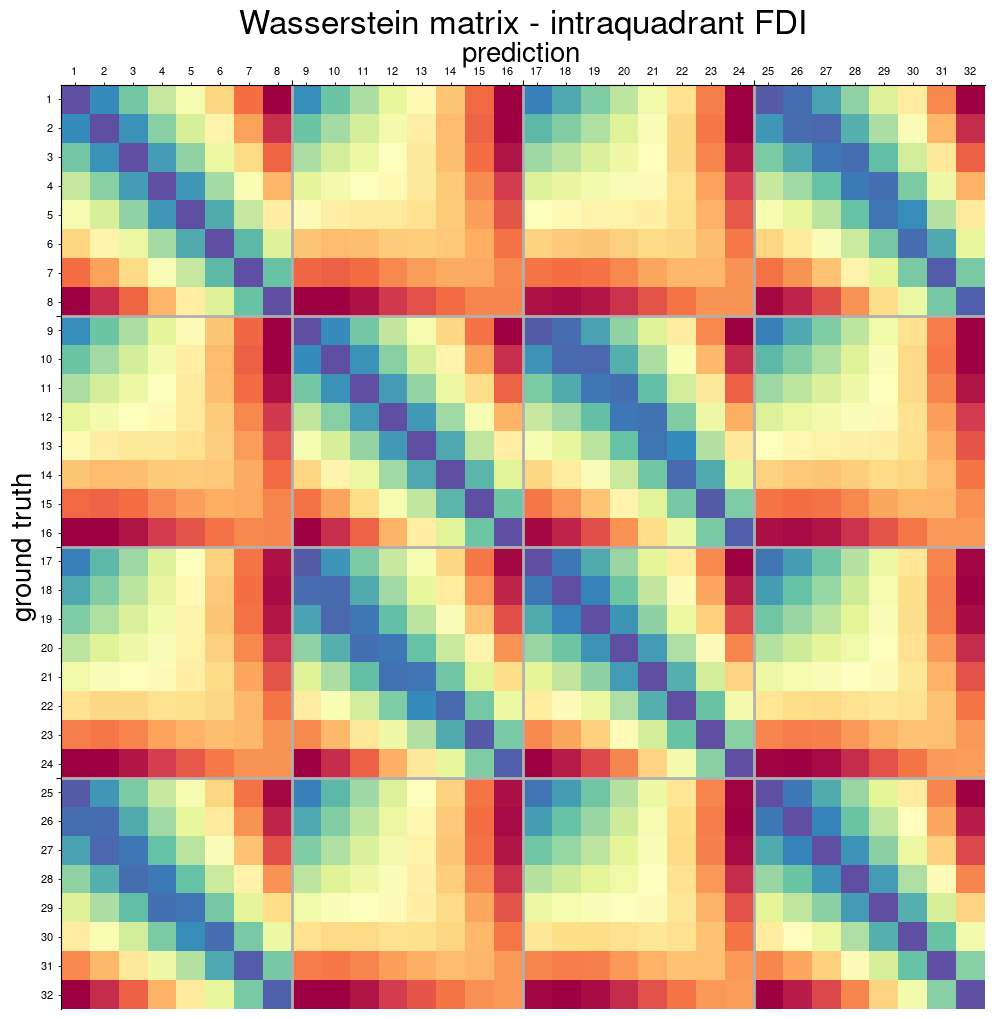

In [52]:
penatlies_matrix_equal = get_combinations([q1,q2,q3,q4], np.ones((4,4)))
penatlies_matrix_equal /= penatlies_matrix_equal.max()
penatlies_matrix_equal_american = fdi2american(penatlies_matrix_equal)

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(penatlies_matrix_equal, cmap='Spectral_r', interpolation='none')
plt.rcParams['grid.color'] = "#ffffff"
ax.set_yticks([7.5, 15.5, 23.5], labels = [], minor=False)
ax.set_xticks([7.5, 15.5, 23.5], labels = [], minor=False)
ax.set_xticks(list(range(0,32)), labels=list(range(1,33)), minor=True, fontsize=8)
ax.set_yticks(list(range(0,32)), labels=list(range(1,33)), minor=True, fontsize=8)
ax.yaxis.grid(True, which='major', linewidth=2)
ax.xaxis.grid(True, which='major', linewidth=2)
ax.set_xlabel('prediction')
ax.set_ylabel('ground truth')
ax.xaxis.set_label_position('top') 
plt.title('Wasserstein matrix - intraquadrant FDI')
plt.show()

# CONFIG 0 - American notation, arch geometry, no weights

quadrant weights: 
 [[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]


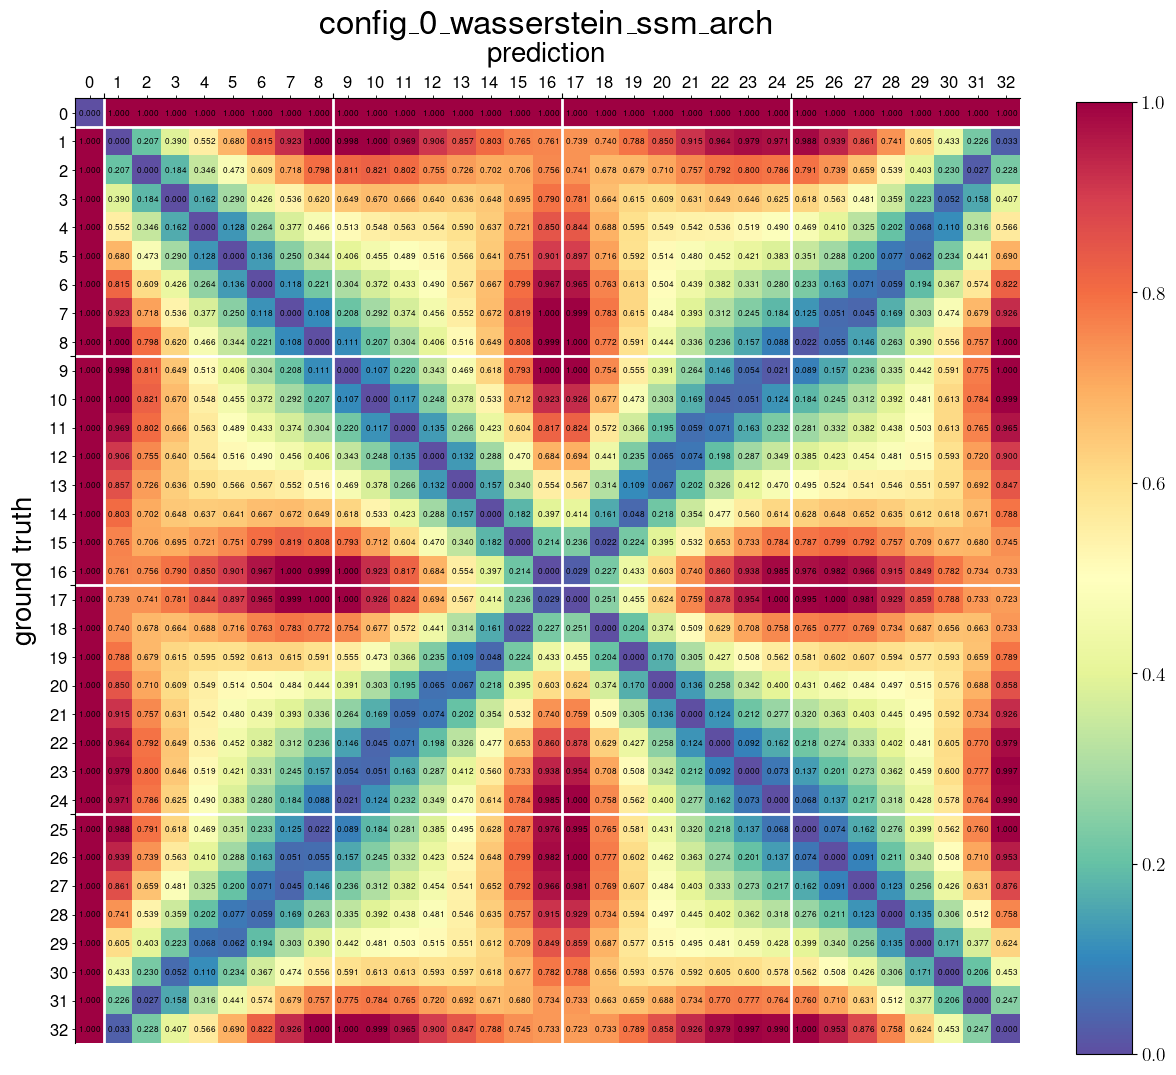

In [53]:
create_visualize_wass_matrix([q1,q2,q3,q4], weights=[1,1,1,1], config_name="config_0_wasserstein_ssm_arch", mode="multiply", geometry="arch",
                             is_sqrt=False, plot_title=None, isShowPreview3D=False)

---

# QUADRANT GEOMETRY - SEMANTICAL ERROR

___

## PENALTIES 8 - quadrant geometry, addition

# weights: 0, 0.1, 0.2, 0.3

quadrant weights: 
 [[0.  0.1 0.3 0.2]
 [0.1 0.  0.2 0.3]
 [0.3 0.2 0.  0.1]
 [0.2 0.3 0.1 0. ]]


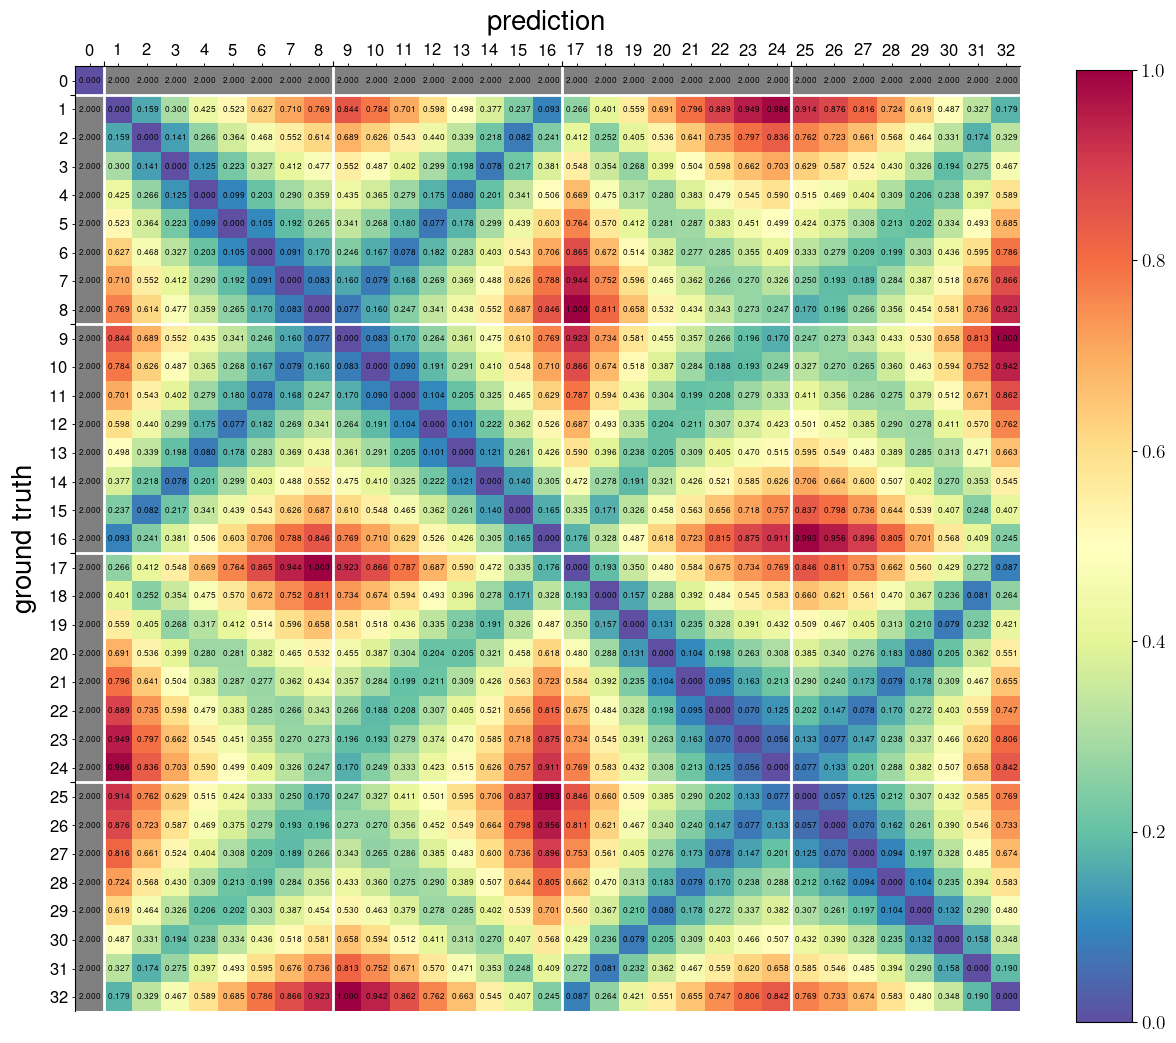

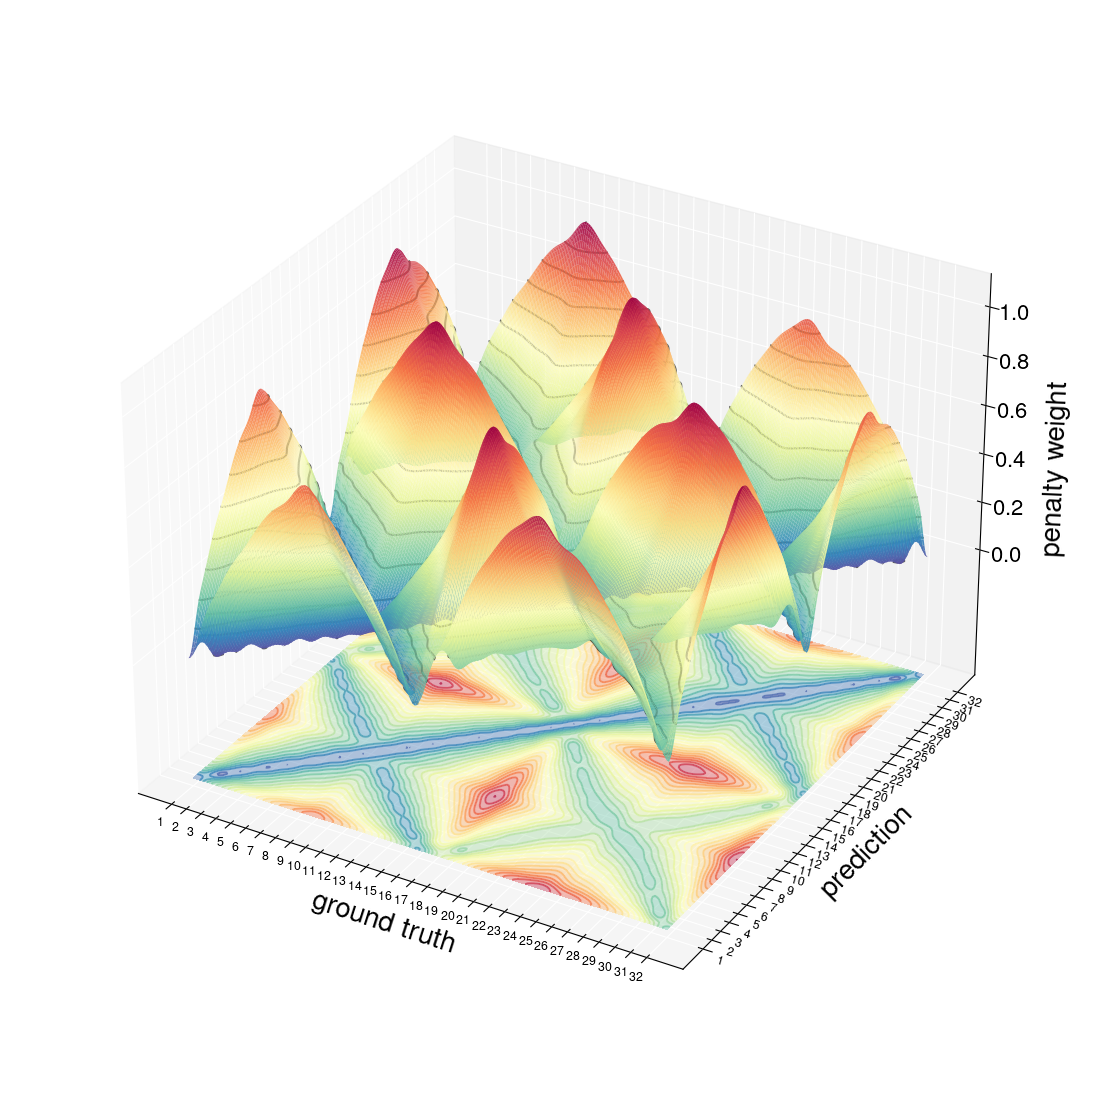

In [64]:
create_visualize_wass_matrix([q1,q2,q3,q4], weights=[0,0.1,0.2,0.3], config_name="config_8_wasserstein_ssm_quad_w_add", mode="add", geometry="quadrant",
                             is_sqrt=False, plot_title='', isShowPreview3D=True, background_val=2, isAnnotateValues=True, above_color='gray')

___

## RANDOM CONFIG - Sanity check

In [100]:
np.random.seed(48)
random_matrix = np.random.uniform(low=1e-5, high=1.0, size=(32,32))
symmetric_random_matrix = np.triu(random_matrix) + np.triu(random_matrix, 1).T
np.fill_diagonal (symmetric_random_matrix,0)
symmetric_random_matrix

array([[0.    , 0.8916, 0.2849, ..., 0.3806, 0.4016, 0.6793],
       [0.8916, 0.    , 0.0374, ..., 0.3926, 0.1427, 0.907 ],
       [0.2849, 0.0374, 0.    , ..., 0.8065, 0.2688, 0.2415],
       ...,
       [0.3806, 0.3926, 0.8065, ..., 0.    , 0.4746, 0.4002],
       [0.4016, 0.1427, 0.2688, ..., 0.4746, 0.    , 0.8861],
       [0.6793, 0.907 , 0.2415, ..., 0.4002, 0.8861, 0.    ]])

quadrant weights: 
 [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
using precomputed matrix


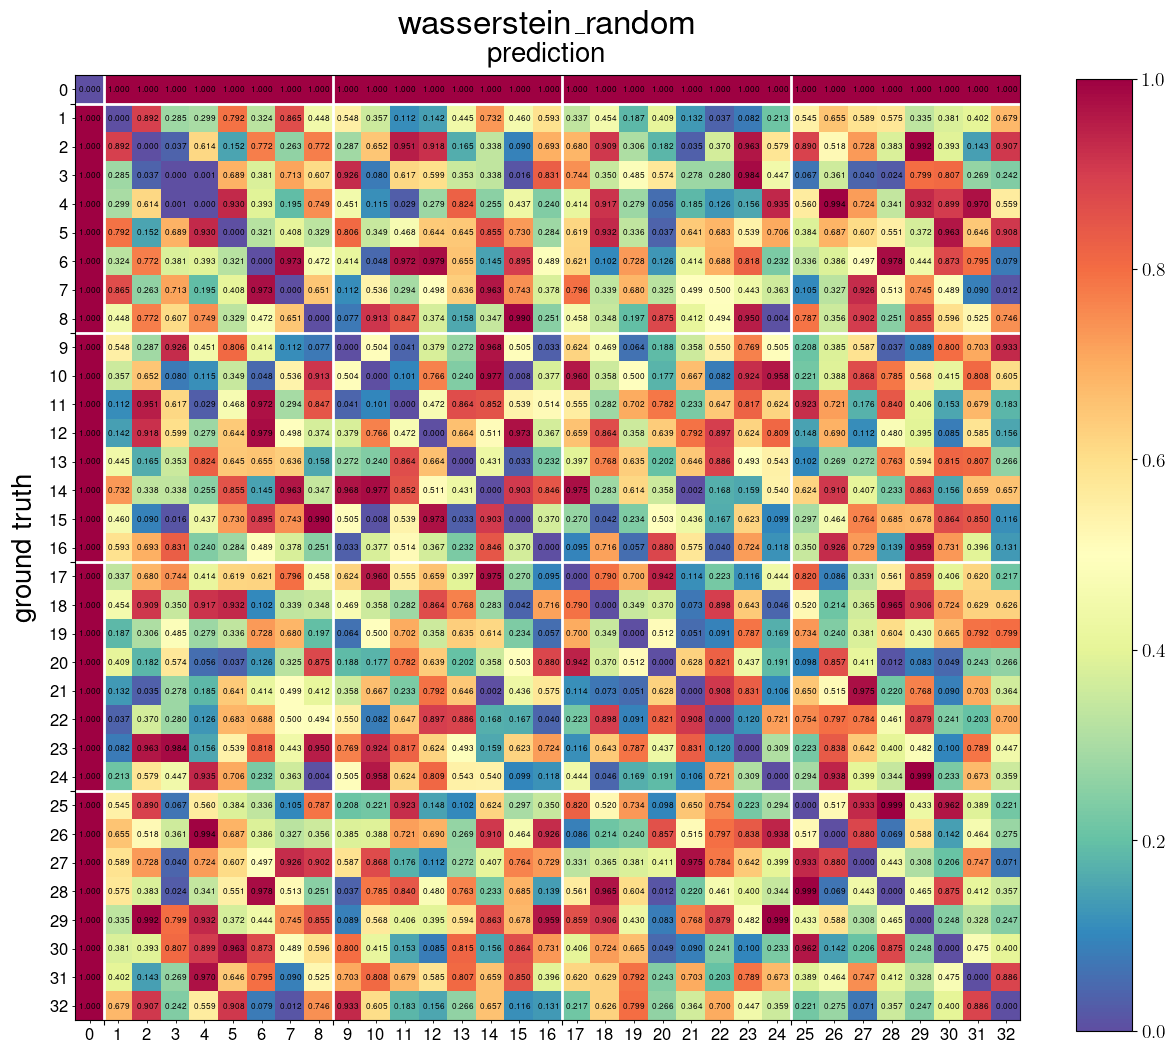

In [99]:
create_visualize_wass_matrix([q1,q2,q3,q4], weights=[0,0,0,0], config_name="wasserstein_random", mode="add", geometry="quadrant",
                             is_sqrt=True, plot_title=None, isShowPreview3D=False, precomputed_matrix=symmetric_random_matrix)

# ONES MATRIX - SANITY CHECK 2

In [119]:
ones_matrix = np.ones((32,32)) - np.eye(32)
ones_matrix

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

quadrant weights: 
 [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
using precomputed matrix


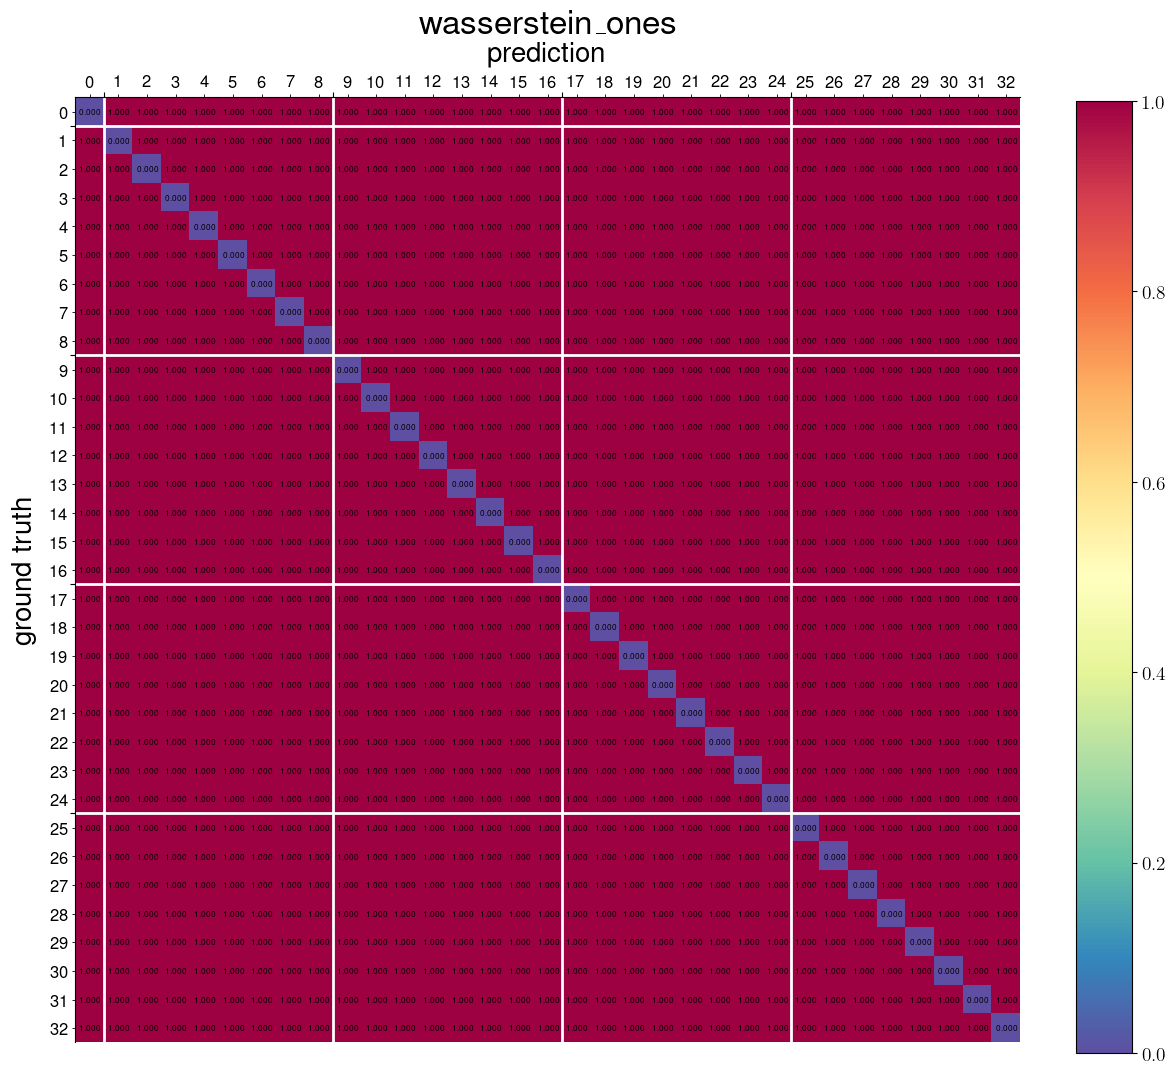

In [120]:
create_visualize_wass_matrix([q1,q2,q3,q4], weights=[0,0,0,0], config_name="wasserstein_ones", mode="add", geometry="quadrant",
                             is_sqrt=True, plot_title=None, isShowPreview3D=False, precomputed_matrix=ones_matrix)

## ADJACENCY AS WASSERSTEIN PENALTIES

PENALTIES 

correct classification = 0,
neighbour = 0.5,
misclassification = 1.

In [121]:
#CONSTRUCT ADJACENCY MATRIX
all_teeth = list(range(1,33))
american_teeth_neighbours_dict = {k:list(set([v, v+1, v-1, x])) for k,v,x in zip(all_teeth, all_teeth, all_teeth[::-1])}
american_teeth_neighbours_dict [1] = [2,32,1]
american_teeth_neighbours_dict [32] = [32,1,31]
american_teeth_neighbours_dict 


{1: [2, 32, 1],
 2: [1, 2, 3, 31],
 3: [2, 3, 4, 30],
 4: [29, 3, 4, 5],
 5: [28, 4, 5, 6],
 6: [27, 5, 6, 7],
 7: [8, 26, 6, 7],
 8: [8, 9, 25, 7],
 9: [8, 9, 10, 24],
 10: [9, 10, 11, 23],
 11: [10, 11, 12, 22],
 12: [21, 11, 12, 13],
 13: [20, 12, 13, 14],
 14: [19, 13, 14, 15],
 15: [16, 18, 14, 15],
 16: [16, 17, 15],
 17: [16, 17, 18],
 18: [17, 18, 19, 15],
 19: [18, 19, 20, 14],
 20: [13, 19, 20, 21],
 21: [12, 20, 21, 22],
 22: [11, 21, 22, 23],
 23: [24, 10, 22, 23],
 24: [24, 25, 9, 23],
 25: [24, 25, 26, 8],
 26: [25, 26, 27, 7],
 27: [26, 27, 28, 6],
 28: [5, 27, 28, 29],
 29: [4, 28, 29, 30],
 30: [3, 29, 30, 31],
 31: [32, 2, 30, 31],
 32: [32, 1, 31]}

In [122]:
american_adjacency_matrix = nx.adjacency_matrix(nx.from_dict_of_lists(american_teeth_neighbours_dict)).todense()

quadrant weights: 
 [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
using precomputed matrix


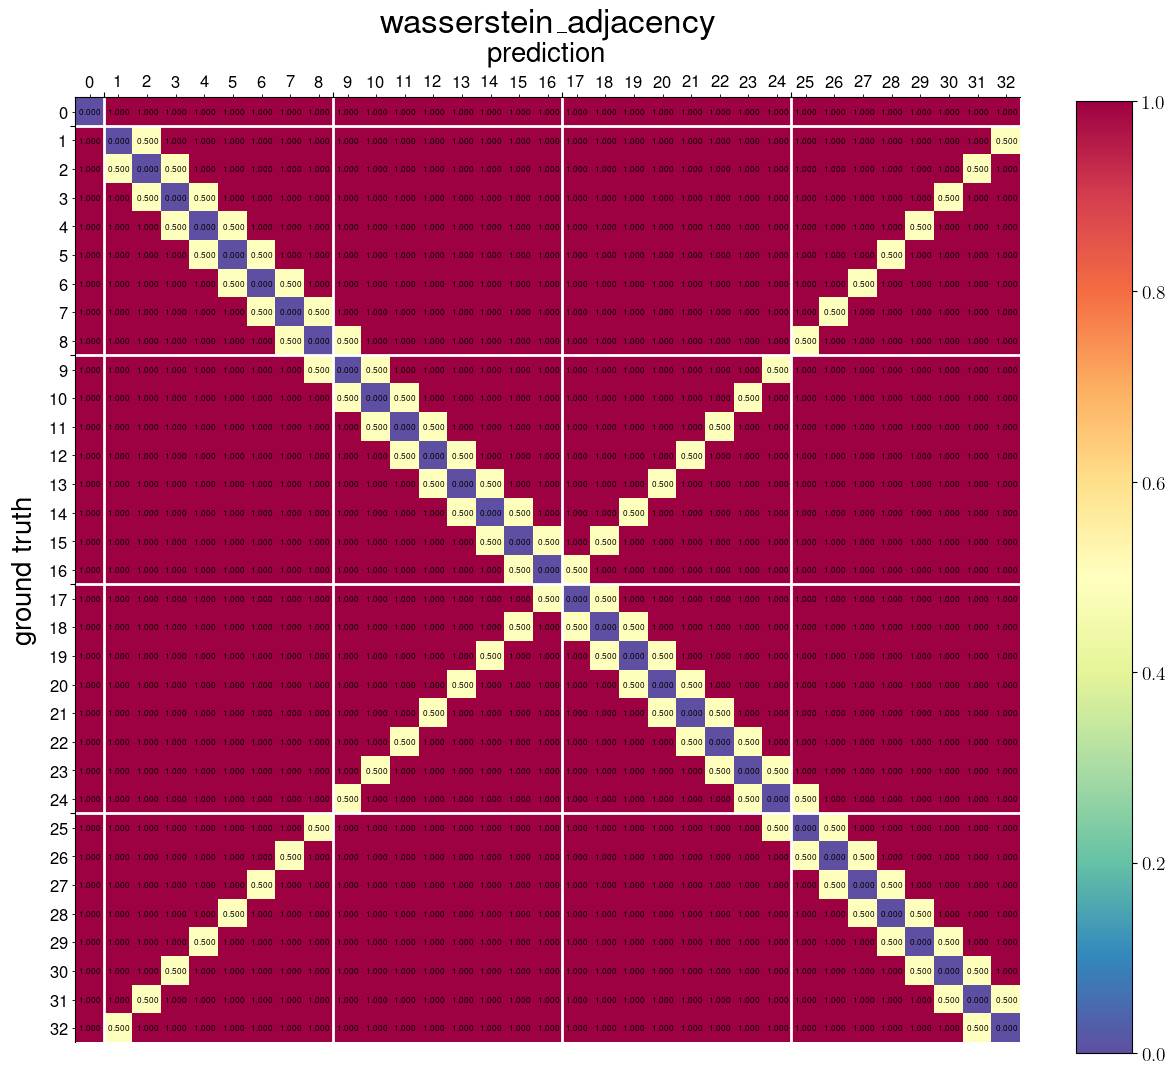

In [123]:
adjacency_penalties = (np.ones((32,32))-np.eye((32))) * (np.ones((32,32)) - american_adjacency_matrix*0.5)
create_visualize_wass_matrix([q1,q2,q3,q4], weights=[0,0,0,0], config_name="wasserstein_adjacency", mode="add", geometry="quadrant",
                             is_sqrt=True, plot_title=None, isShowPreview3D=False, precomputed_matrix=adjacency_penalties)